# Comparing conventional and approximate Single-Output GPs training time and loss over number of samples

In [1]:
import math
import time
import gc

import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

import famgpytorch

%matplotlib inline
%load_ext autoreload
%autoreload 2
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on {torch.cuda.get_device_name(device) if torch.cuda.is_available() else 'CPU'}.")

Training on NVIDIA GeForce RTX 3080.


### Define Models
- Gaussian Likelihood
- Zero Mean

In [2]:
class ConventionalGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_inputs, train_targets, likelihood):
        super(ConventionalGPModel, self).__init__(train_inputs, train_targets, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ZeroMean(), num_tasks=2
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

class ApproxGPModel15(gpytorch.models.ExactGP):
    def __init__(self, train_inputs, train_targets, likelihood):
        super(ApproxGPModel15, self).__init__(train_inputs, train_targets, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ZeroMean(), num_tasks=2
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            famgpytorch.kernels.RBFKernelApprox(number_of_eigenvalues=15), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

class ApproxGPModel5(gpytorch.models.ExactGP):
    def __init__(self, train_inputs, train_targets, likelihood):
        super(ApproxGPModel5, self).__init__(train_inputs, train_targets, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ZeroMean(), num_tasks=2
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            famgpytorch.kernels.RBFKernelApprox(number_of_eigenvalues=5), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

### Set up helper functions used to repeat training and measure time

In [3]:
def train_gp(model_type, nb_training_points):
    train_x = torch.linspace(0, 1, nb_training_points, device=device)
    train_y = torch.stack([
        torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size(), device=device) * math.sqrt(0.04),
        torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size(), device=device) * math.sqrt(0.04),
    ], -1)

    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
    likelihood.to(device)
    model = model_type(train_x, train_y, likelihood)
    model.to(device)

    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    start = time.perf_counter()
    for i in range(10):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()
    end = time.perf_counter()

    return end-start, -mll(model(train_x), train_y).item()

def eval_gp(model, likelihood, nb_test_points):
    test_x = torch.linspace(0, 1, nb_test_points, device=device)

    model.eval()
    likelihood.eval()

    start = time.perf_counter()
    with torch.no_grad():
        observed_pred = likelihood(model(test_x))
    end = time.perf_counter()

    return observed_pred, end-start

def repeat_train(model_type, training_sample_nbs):

    training_times = np.empty(len(training_sample_nbs), dtype=float)
    training_losses = np.empty(len(training_sample_nbs), dtype=float)

    for idx, train_sample_nb in enumerate(training_sample_nbs):
        train_time, current_loss = train_gp(
            model_type, nb_training_points=train_sample_nb
        )

        training_times[idx] = train_time
        training_losses[idx] = current_loss

        # Make sure everything unnecessary is deleted from memory for next run
        gc.collect()
        torch.cuda.empty_cache()

    return training_times, training_losses

### Repeat the training for models and plot

In [4]:
sample_nbs = np.arange(2000, 4001, 2000)
train_t = np.empty((3, len(sample_nbs)), dtype=float)
train_l = np.empty((3, len(sample_nbs)), dtype=float)

train_t[0], train_l[0] = repeat_train(ConventionalGPModel, sample_nbs)
train_t[1], train_l[1] = repeat_train(ApproxGPModel15, sample_nbs)
train_t[2], train_l[2] = repeat_train(ApproxGPModel5, sample_nbs)

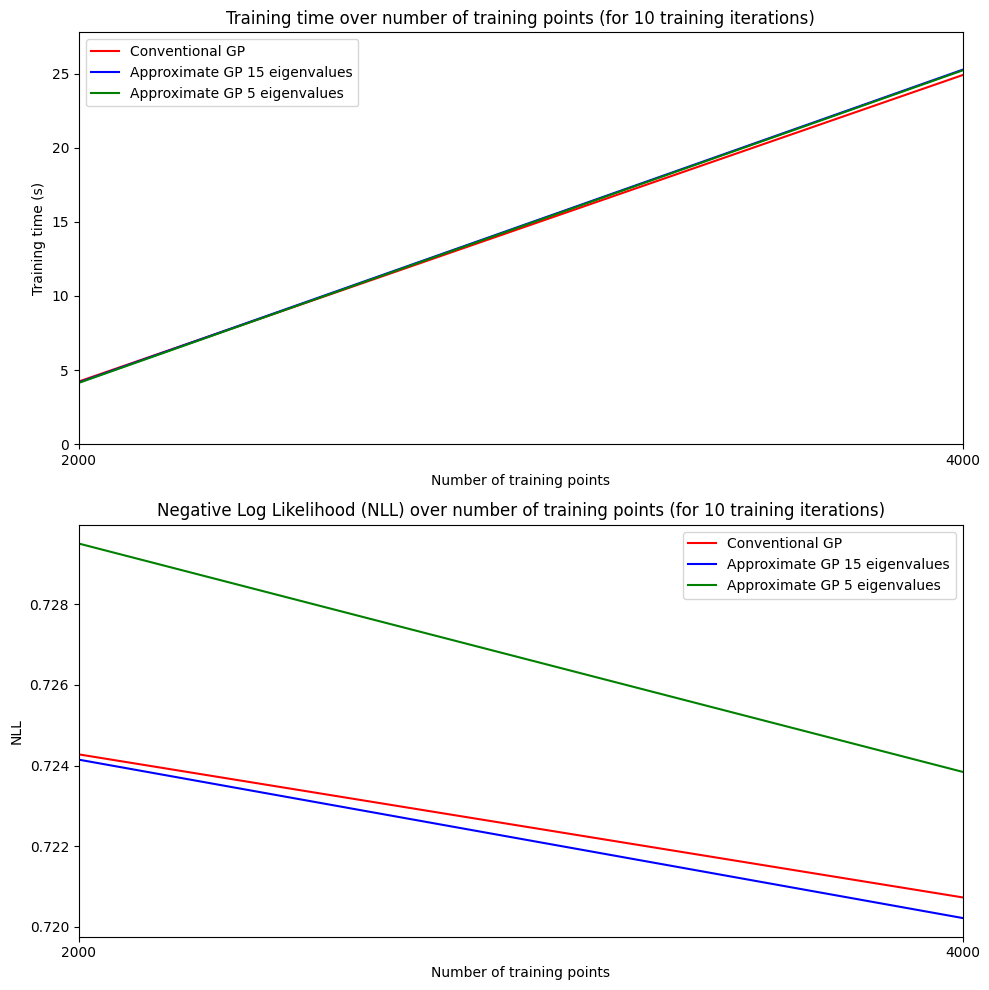

In [5]:
# plot results
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

x_min, x_max = np.min(sample_nbs), np.max(sample_nbs)
y_max = np.max(train_t)

# plot training time
ax1.set_title("Training time over number of training points (for 10 training iterations)")
ax1.set_xlabel("Number of training points")
ax1.set_ylabel("Training time (s)")

ax1.plot(sample_nbs, train_t[0], 'r')
ax1.plot(sample_nbs, train_t[1], 'b')
ax1.plot(sample_nbs, train_t[2], 'g')

ax1.set_ylim(0, y_max + y_max / 10)
ax1.set_xlim(x_min, x_max)
ax1.set_xticks(sample_nbs)
ax1.legend(["Conventional GP", "Approximate GP 15 eigenvalues", "Approximate GP 5 eigenvalues"])

# plot loss
ax2.set_title("Negative Log Likelihood (NLL) over number of training points (for 10 training iterations)")
ax2.set_xlabel("Number of training points")
ax2.set_ylabel("NLL")

ax2.plot(sample_nbs, train_l[0], 'r')
ax2.plot(sample_nbs, train_l[1], 'b')
ax2.plot(sample_nbs, train_l[2], 'g')

ax2.set_xlim(x_min, x_max)
ax2.set_xticks(sample_nbs)
ax2.legend(["Conventional GP", "Approximate GP 15 eigenvalues", "Approximate GP 5 eigenvalues"])

f.tight_layout()

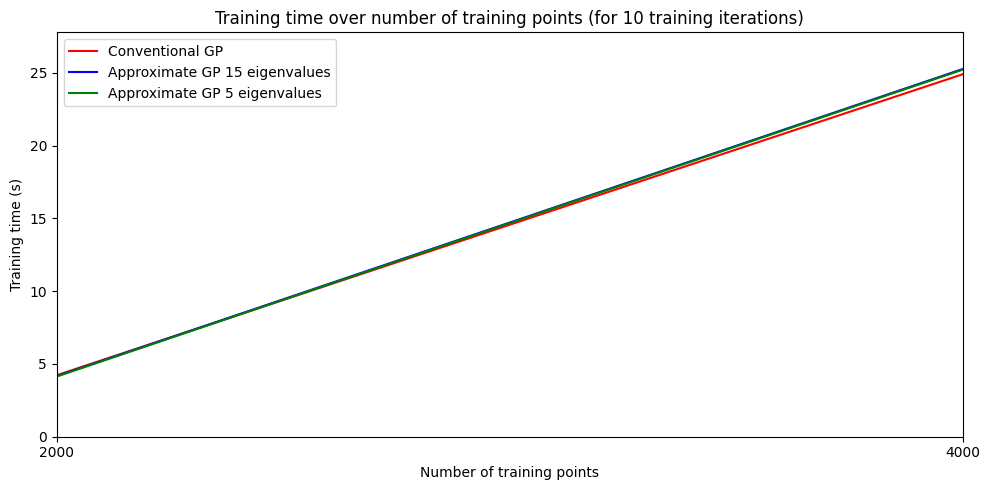

In [6]:
# plot results
f, ax1 = plt.subplots(1, 1, figsize=(10, 5))

x_min, x_max = np.min(sample_nbs), np.max(sample_nbs)
y_max = np.max(train_t[1:])

# plot training time
ax1.set_title("Training time over number of training points (for 10 training iterations)")
ax1.set_xlabel("Number of training points")
ax1.set_ylabel("Training time (s)")

ax1.plot(sample_nbs, train_t[0], 'r')
ax1.plot(sample_nbs, train_t[1], 'b')
ax1.plot(sample_nbs, train_t[2], 'g')

ax1.set_ylim(0, y_max + y_max / 10)
ax1.set_xlim(x_min, x_max)
ax1.set_xticks(sample_nbs)
ax1.legend(["Conventional GP", "Approximate GP 15 eigenvalues", "Approximate GP 5 eigenvalues"])

f.tight_layout()